# Capstone Vinci - Contour detection

# How to ?

1. [Load the clean data](#1-how-to-load-the-clean-data-segments-)
1. [Load and Iterate through the segments](#2-how-to-load-only-segments-form-geojson)
1. [Plot the plan](#3-how-to-plot-the-plan-in-hd-)
1. 🆕 [Use a model](#4-how-to-use-a-model-)
1. 🆕 [Validate the model](#5-how-to-validate-my-model-)
1. 🆕 [Generate the final GeoJson file?](#6-how-to-generate-the-final-geojson-file-)


In [19]:
%reload_ext autoreload
%autoreload 2

In [40]:
from pathlib import Path

# own inmports
import utils.parse_geojson as pg
from models.model_CVsegmentation import CVSegmentation
from models.model_polygonise import SegmentBasedClustering
from utils.metrics import (
    average_iou,
    average_matched_iou,
    score_model,
    test_model_on_sample,
)
from utils.plots import plot_score

# Example of geojson input
file_path = Path("data/geojson/Output5.geojson")

## 1. How to load a GeoJson file ?
[Back to top ↑](#how-to-)

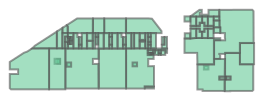

In [21]:
# Without tranformation
gc_raw = pg.load_geometrycollection_from_geojson(file_path)
gc_raw

In [22]:
# With normalization
gc_norm, transform_parameters = pg.load_geojson(file_path)
print(
    f"Saved normalization parameters for inverse transformation : {transform_parameters}"
)
print(f"Loaded {len(gc_norm.geoms)} entities, total {gc_norm.length:.0f}m.")

Saved normalization parameters for inverse transformation : [626.8324607642935, 374.1259288328735, 1]
Loaded 95 entities, total 3594m.


## 2. How to load only segments form GeoJson?
[Back to top ↑](#how-to-)

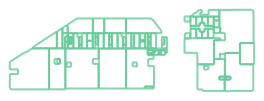

In [23]:
# Get segments in a geometry collection from a raw geojson file

gc_segments = pg.get_segments(file_path)
gc_segments

## 2.bis. How to iterate through the segments?

Segments are into stored into a shapely.GeometryCollection object that is 
iterable through the `gc.geoms` property.
[Back to top ↑](#how-to-)

In [24]:
# use the .geoms property that is iterable
print(type(gc_segments.geoms))

for segment in gc_segments.geoms:
    print(segment)
    # return the coordinates of the two points as ([x1, x2], [y1, y2])
    print(segment.xy)
    break
# >>> <class 'shapely.geometry.base.GeometrySequence'>
# >>> LINESTRING (3.4717383791561587 27.472680807304148, 3.5067598935479767 27.512141737399304)
# >>> (array('d', [3.4717383791561587, 3.5067598935479767]), array('d', [27.472680807304148, 27.512141737399304]))

<class 'shapely.geometry.base.GeometrySequence'>
LINESTRING (814.7756481207723 401.1371993745287, 831.2650232086971 401.1371993745287)
(array('d', [814.7756481207723, 831.2650232086971]), array('d', [401.1371993745287, 401.1371993745287]))


## 3. How to plot the plan in HD ?
[Back to top ↑](#how-to-)

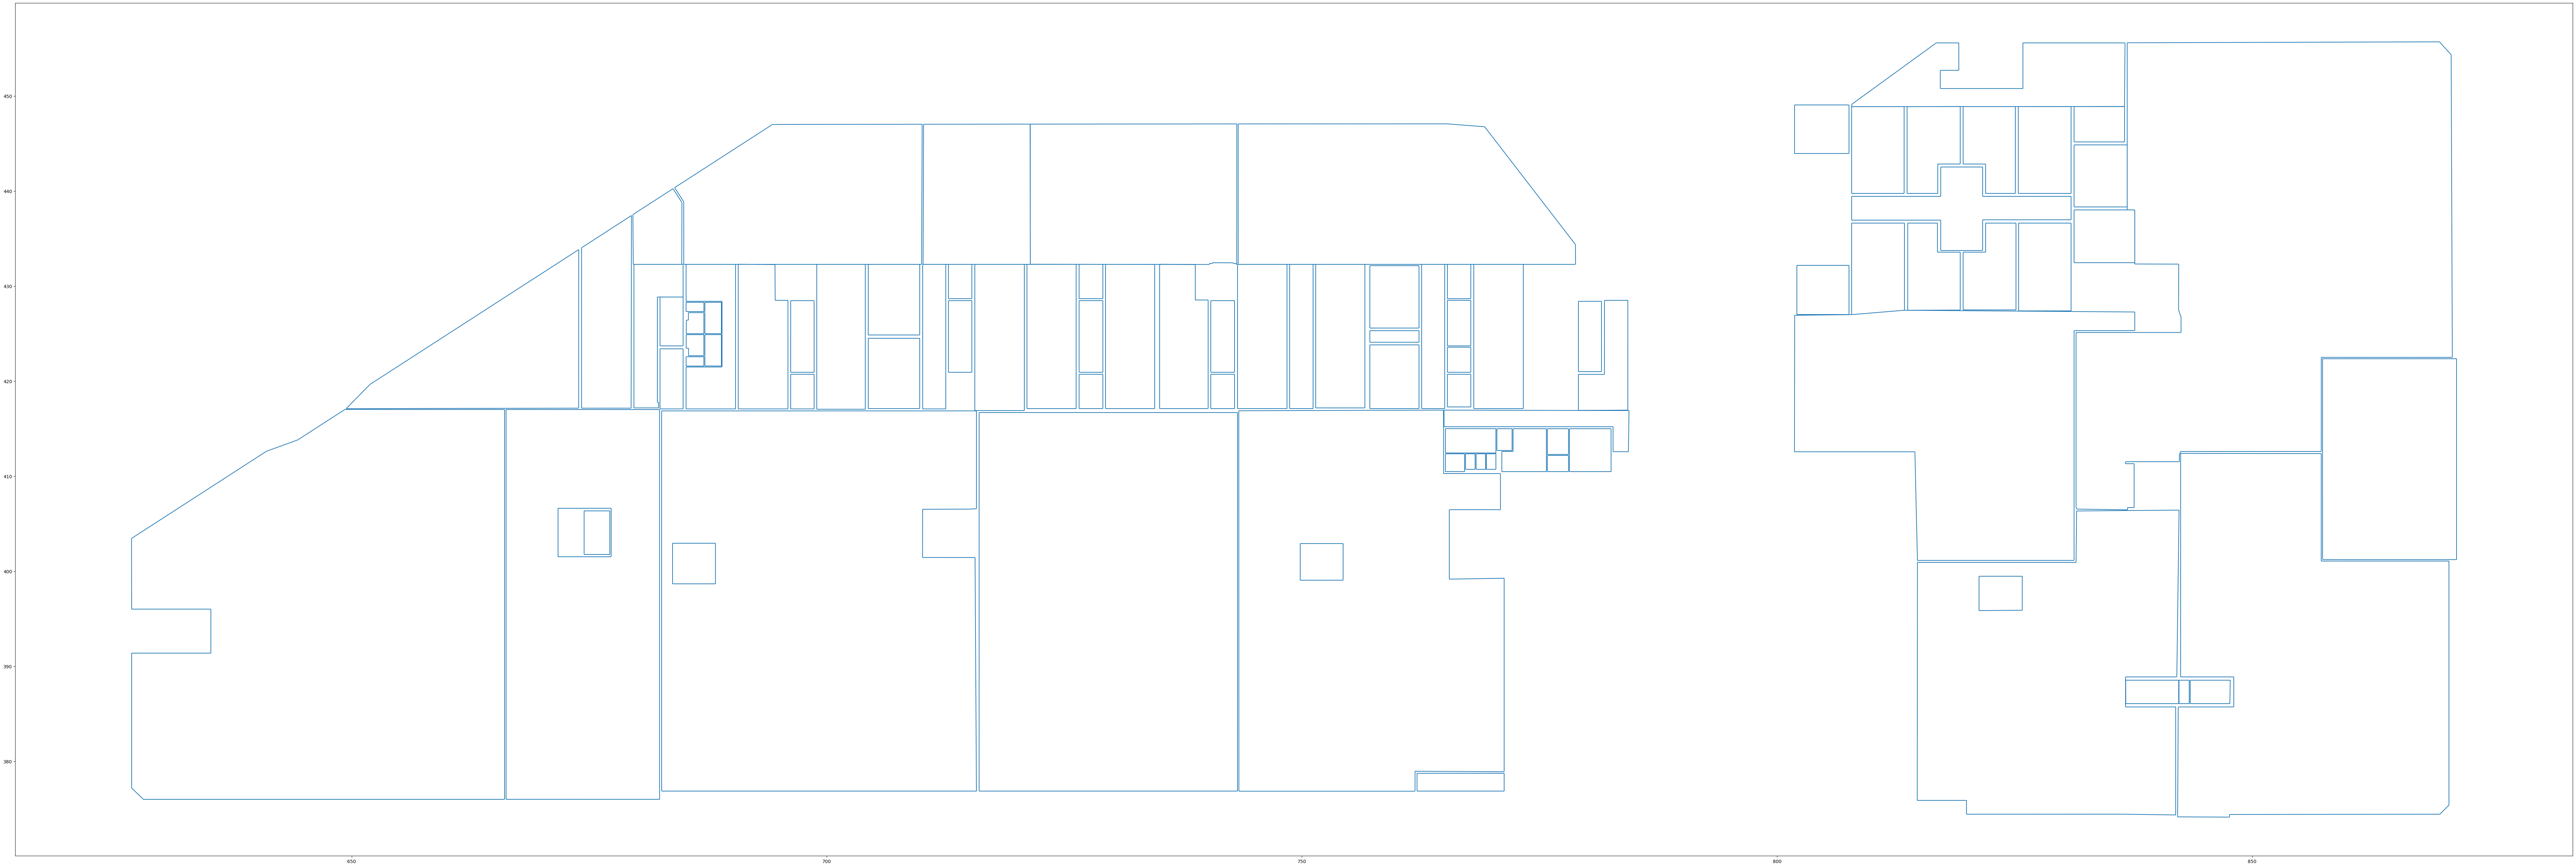

In [25]:
# H1: rise the definition
pg.plot_GeometryCollection(gc_segments, figsize=(100, 100))

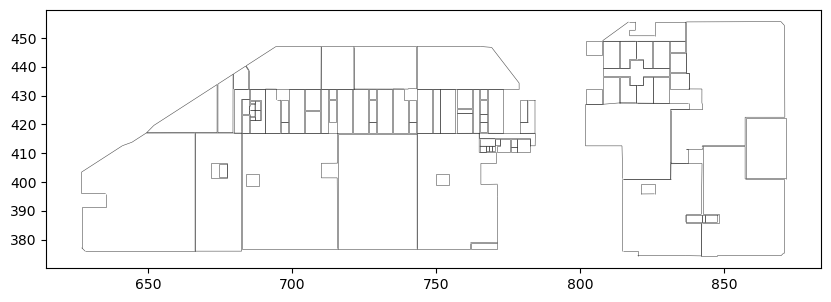

In [26]:
# H2: lower the linewidth. Other pyplot kwargs can be passed to geopandas.GeoSeries.plot
pg.plot_GeometryCollection(
    gc_segments, figsize=(10, 10), color="k", linewidth=0.4, alpha=0.7
)

## 4. How to use a model? 🆕

90 rooms found, displayed as a GeometryCollection:


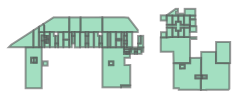

In [27]:
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

Filter: keep 109/117
109 rooms found, displayed as a GeometryCollection:


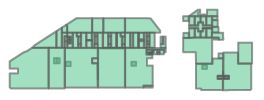

In [28]:
# Example with Computer Vision
model = CVSegmentation()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

100 rooms found, displayed as a GeometryCollection:


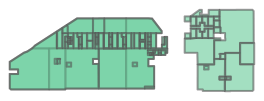

In [29]:
from models.CapstoneVisionSegmentation import CapstoneVisionSegmentation

# Example with CapstoneVisionSegmentation
CVS_model = CapstoneVisionSegmentation()
# Call predict with the loaded geometry collection
y_pred = CVS_model(gc_raw)
print(f"{len(y_pred.geoms)} rooms found, displayed as a GeometryCollection:")
y_pred

## 5. How to validate my model? 🆕

⚠️ **ONLY on a `spaces-walls` folder !** ⚠️

### 5.1 Display the prediction and score on a sample

#### Vector-based model

In [30]:
# Chose a Spaces-Walls folder
validate_subfolder = Path(
    # "data/spaces-walls/NHT Tours/plan_etage_T-T3000"
    "data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres"
    # "data/spaces-walls/CH Lens/CH Lens B1",
)

metric = average_matched_iou

Score: 0.800 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


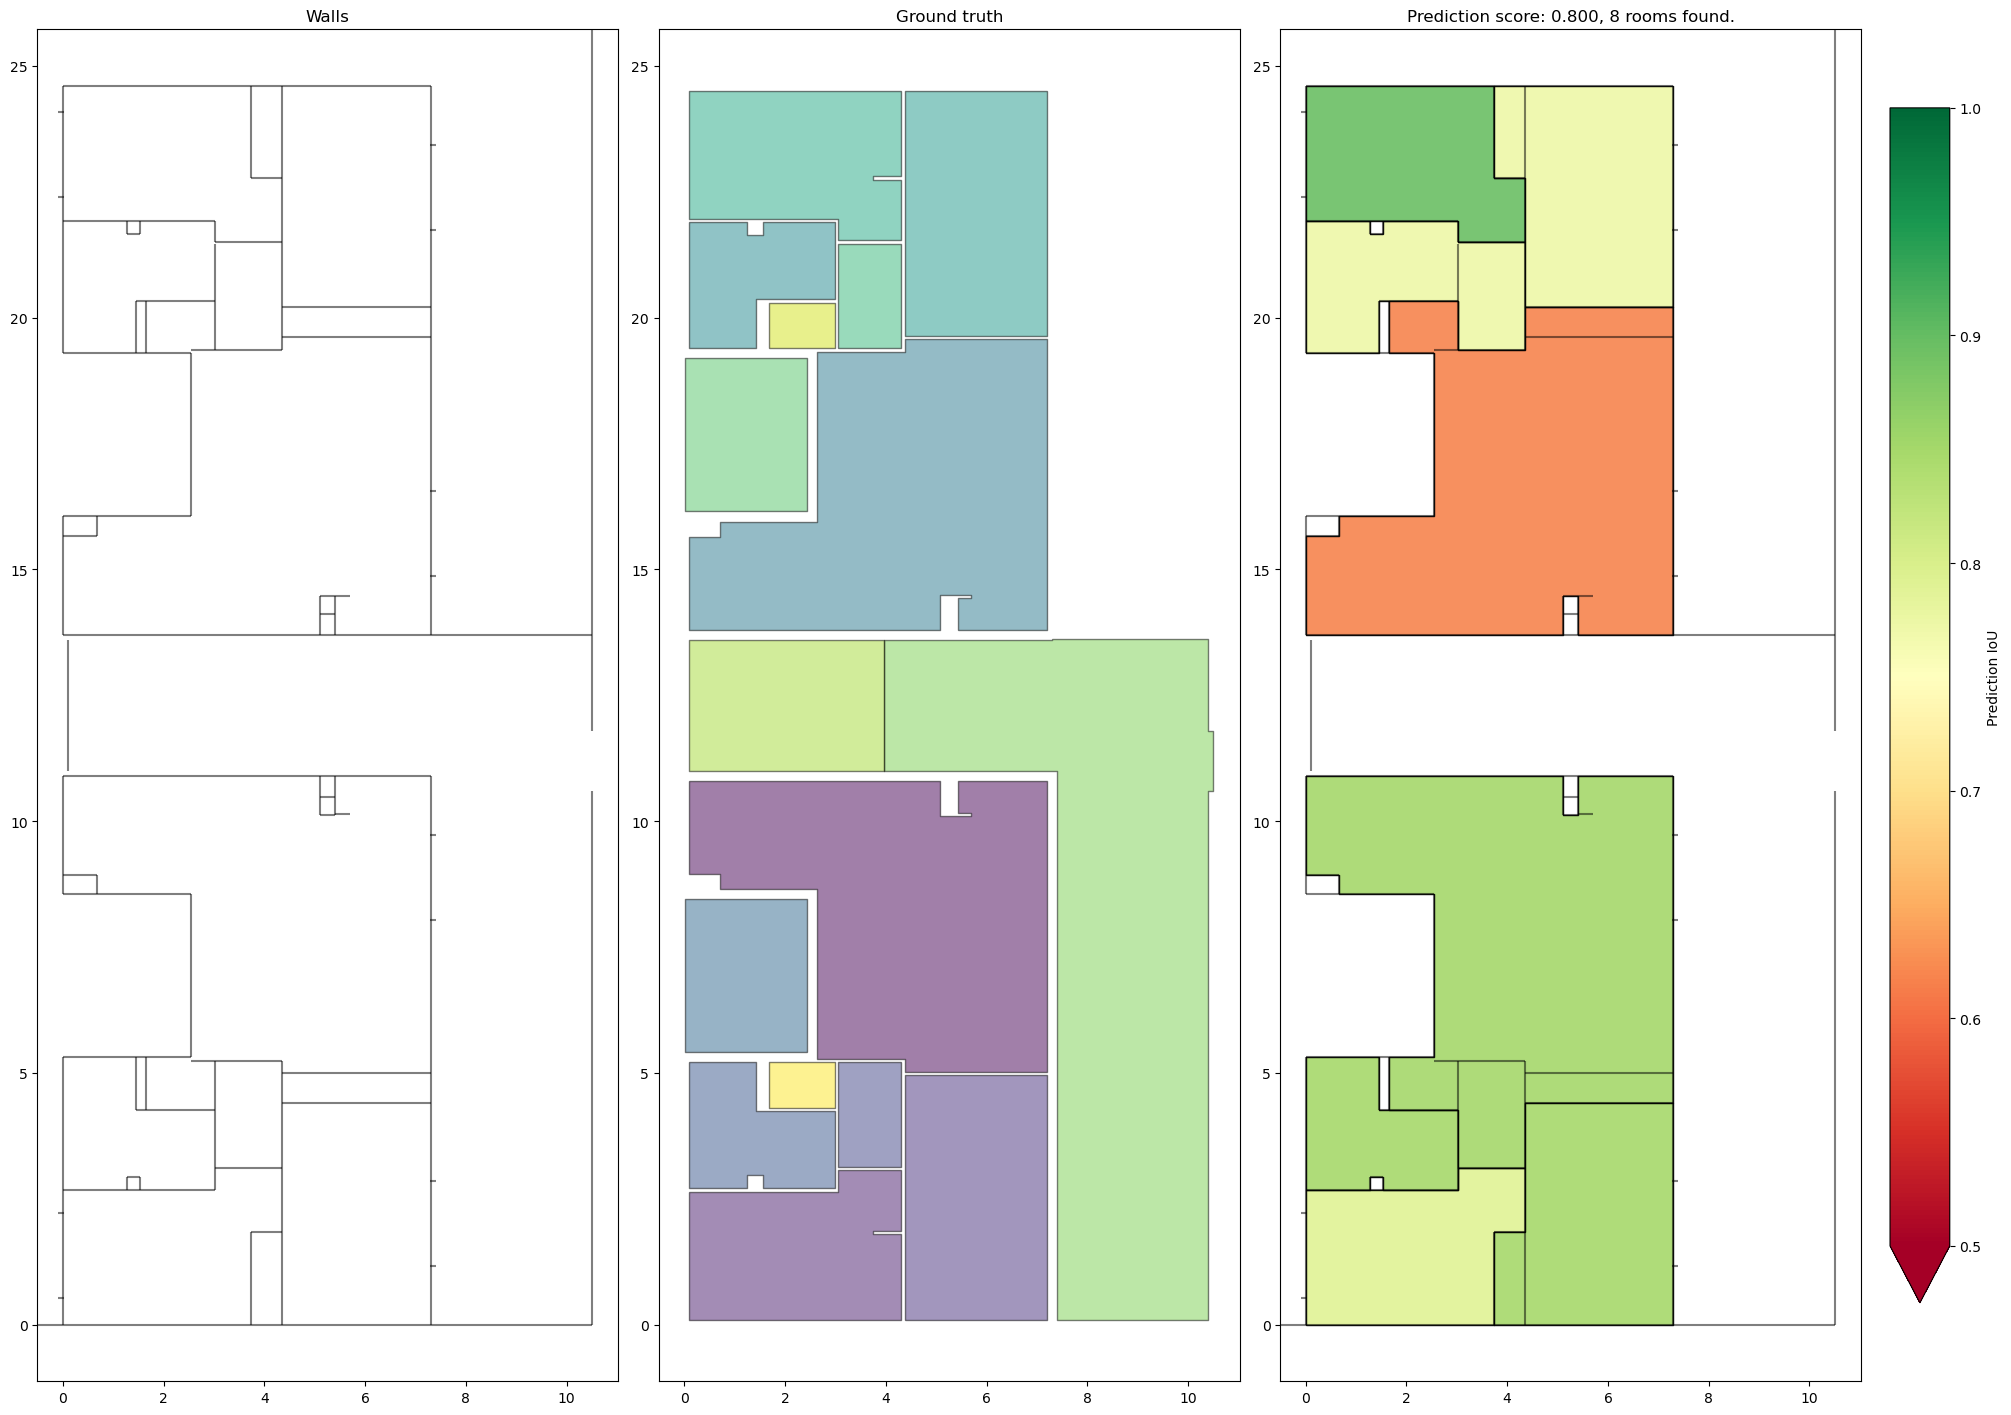

In [31]:
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()

# Compute the metric
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

#### With segment preprocessing

Merging segments, this may take 1 min.
Score: 0.577 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Merging segments, this may take 1 min.


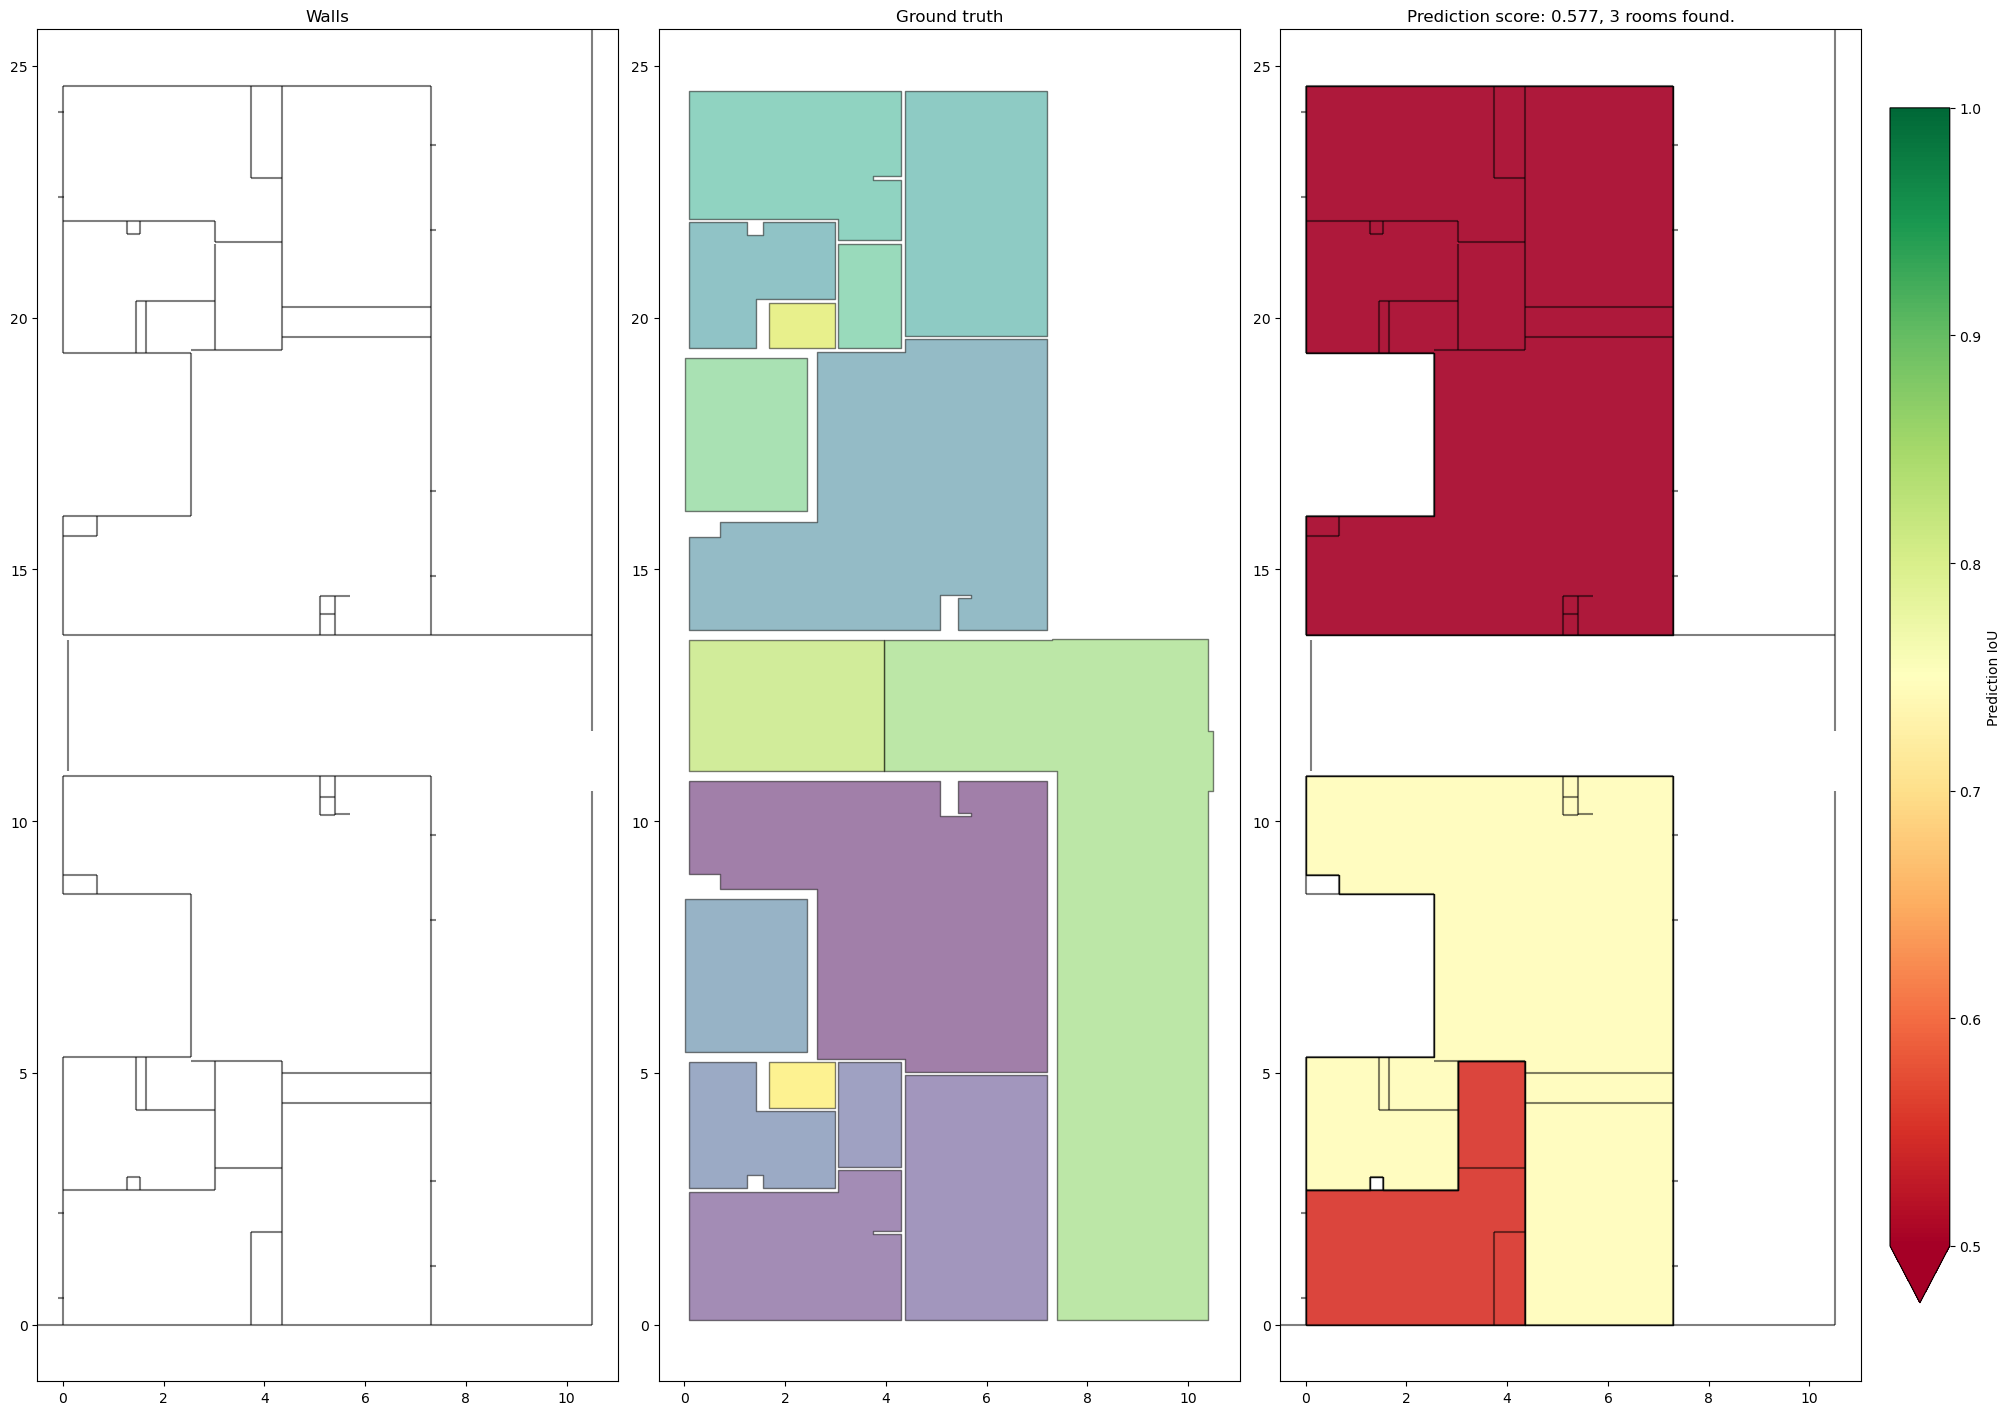

In [32]:
# Same model but with segment preprocessing
model = SegmentBasedClustering(clean_segments=True)
metric = average_matched_iou
# Compute the metric
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

#### Vision-based model

Filter: keep 15/17
Score: 0.605 for CVSegmentation(dpi:50, thickness:11, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Filter: keep 15/17


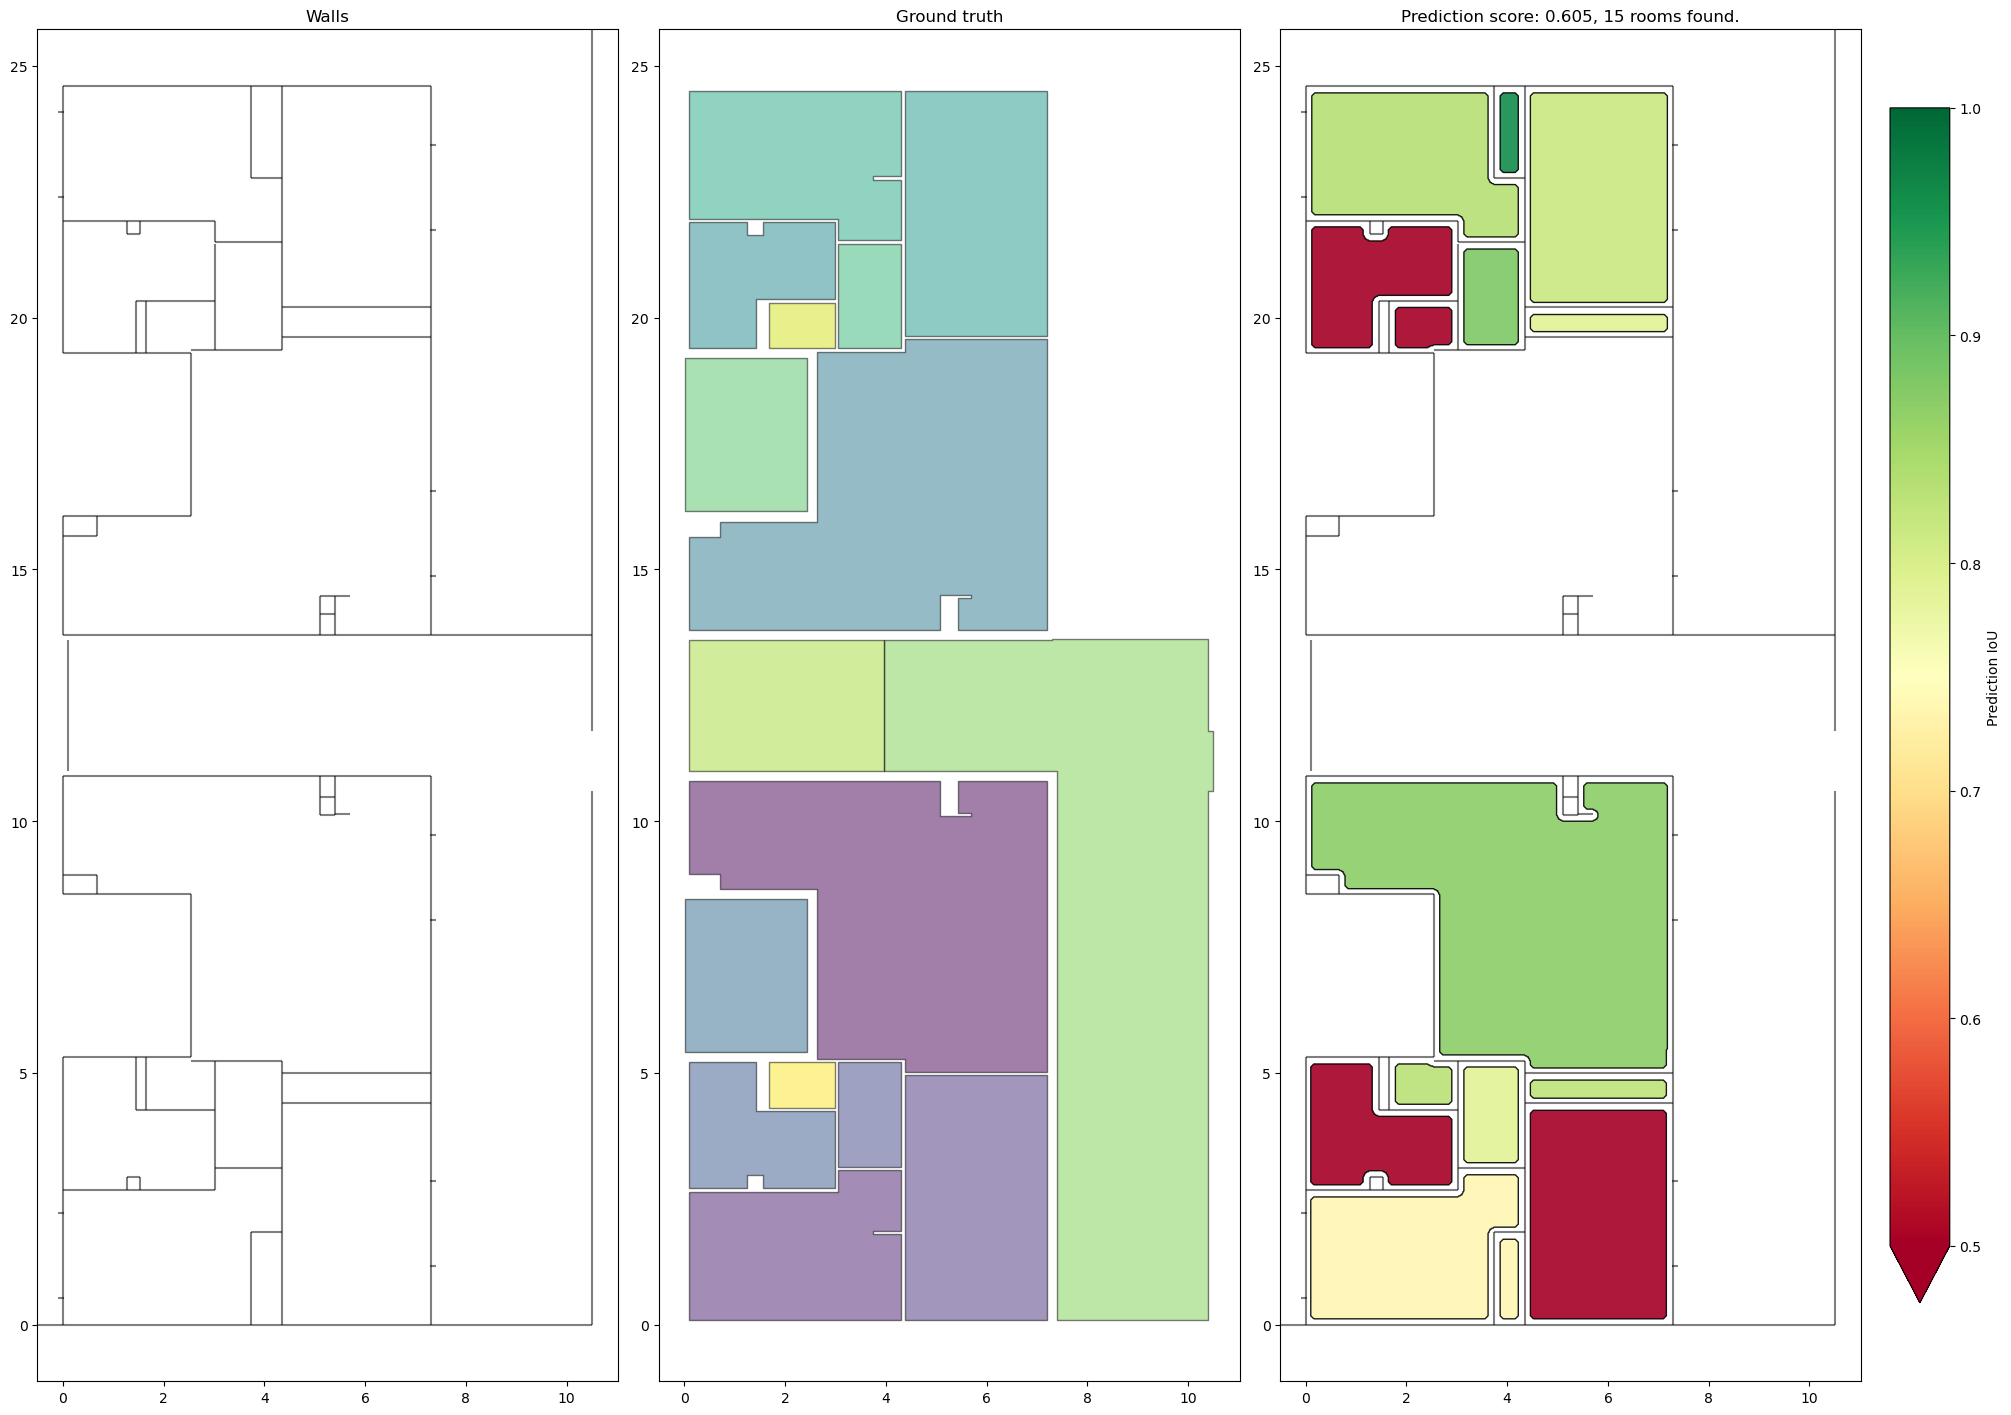

In [33]:
# Example with Computer vision
model = CVSegmentation(thickness=11, surf_min=0.3, surf_max=1_000)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

Filter: keep 15/19
Score: 0.649 for CVSegmentation(dpi:50, thickness:7, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Filter: keep 15/19


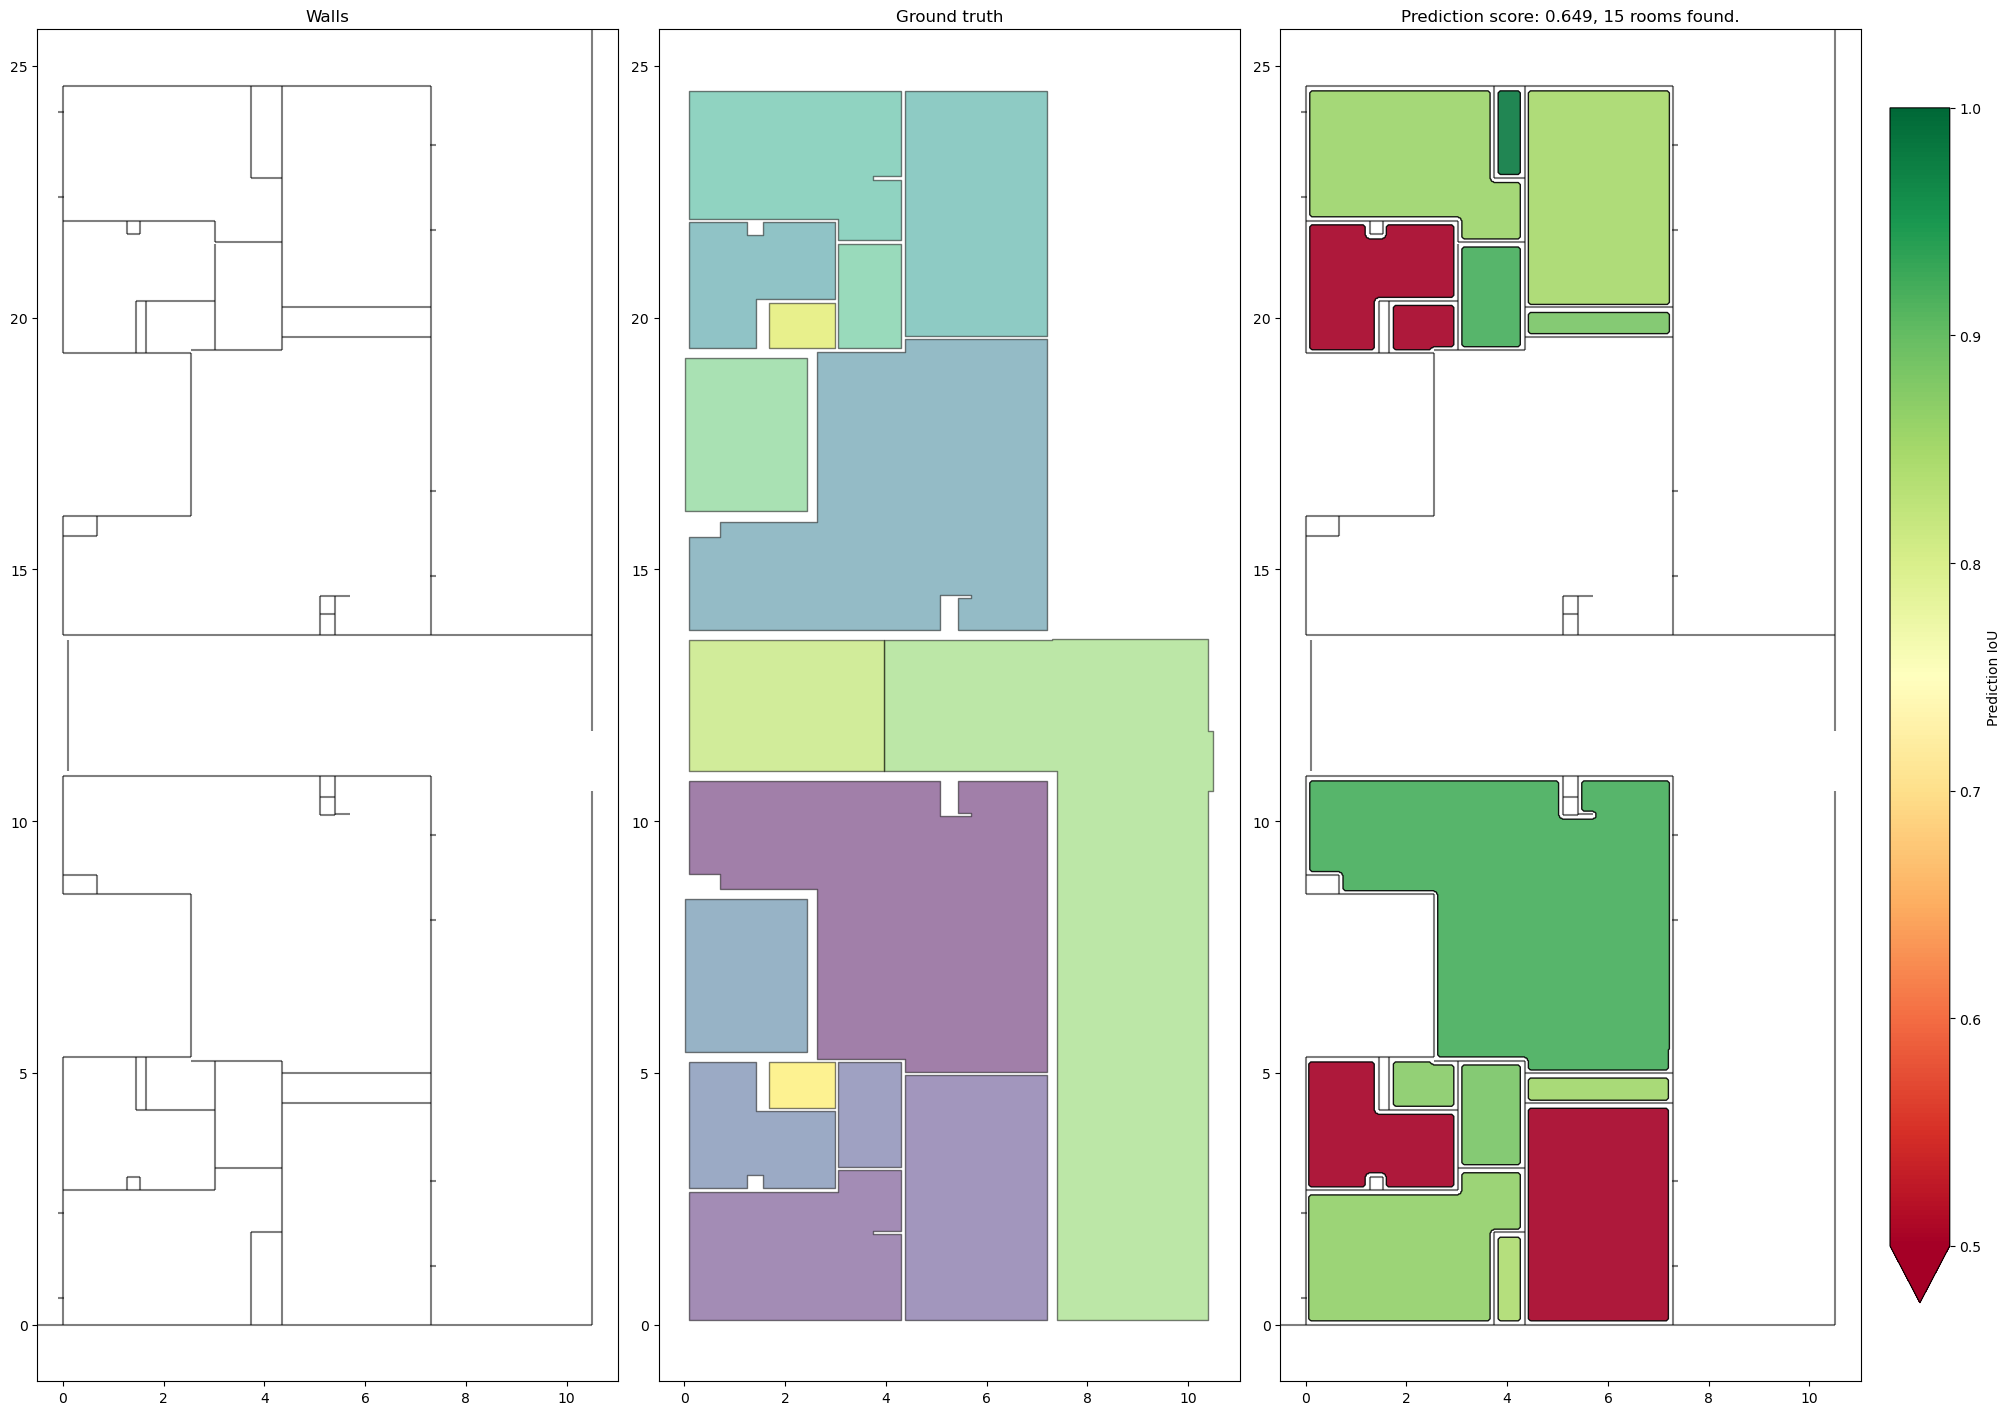

In [34]:
# Example with Computer vision
model = CVSegmentation(thickness=7, surf_min=0.3, surf_max=2_000)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric, show_iou=True).show()

Score: 0.925 for CapstoneSegmentation(dpi:50, thickness:3, method_dilatation:gaussian, surface_min_m2:0.5, surface_min_px:1250.0) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


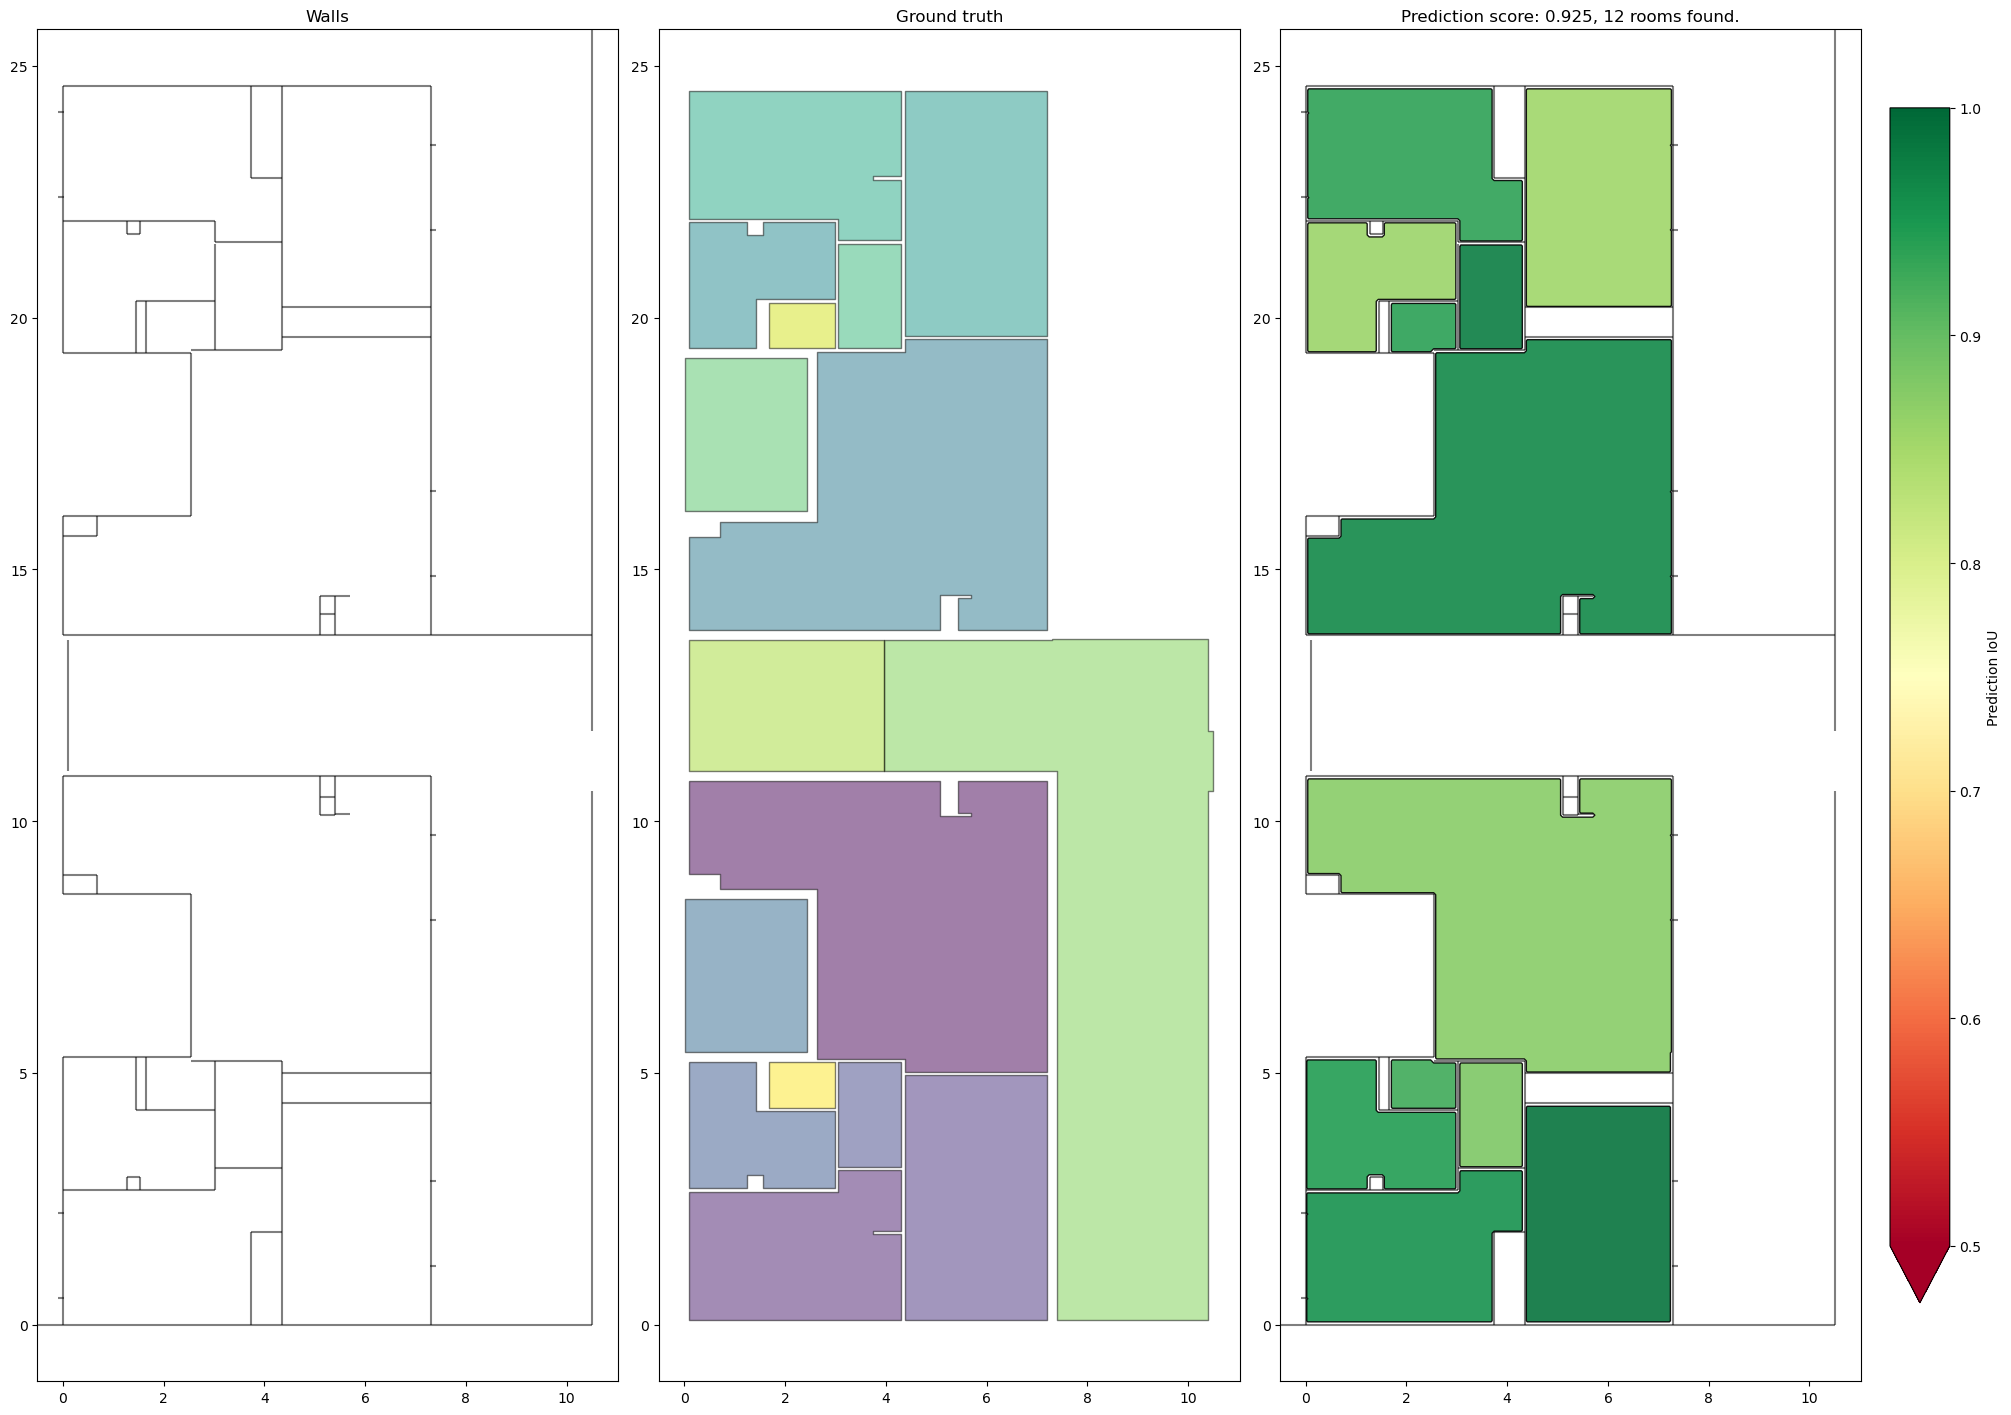

In [35]:
# Example with CapstoneVisionSegmentation

CVS_model = CapstoneVisionSegmentation()
score = test_model_on_sample(
    CVS_model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {CVS_model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(CVS_model, validate_subfolder, metric, show_iou=True).show()

#### With segment preprocessing

Merging segments, this may take 1 min.
Filter: keep 2/5
Score: 0.598 for CVSegmentation(dpi:50, thickness:13, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Merging segments, this may take 1 min.
Filter: keep 2/5


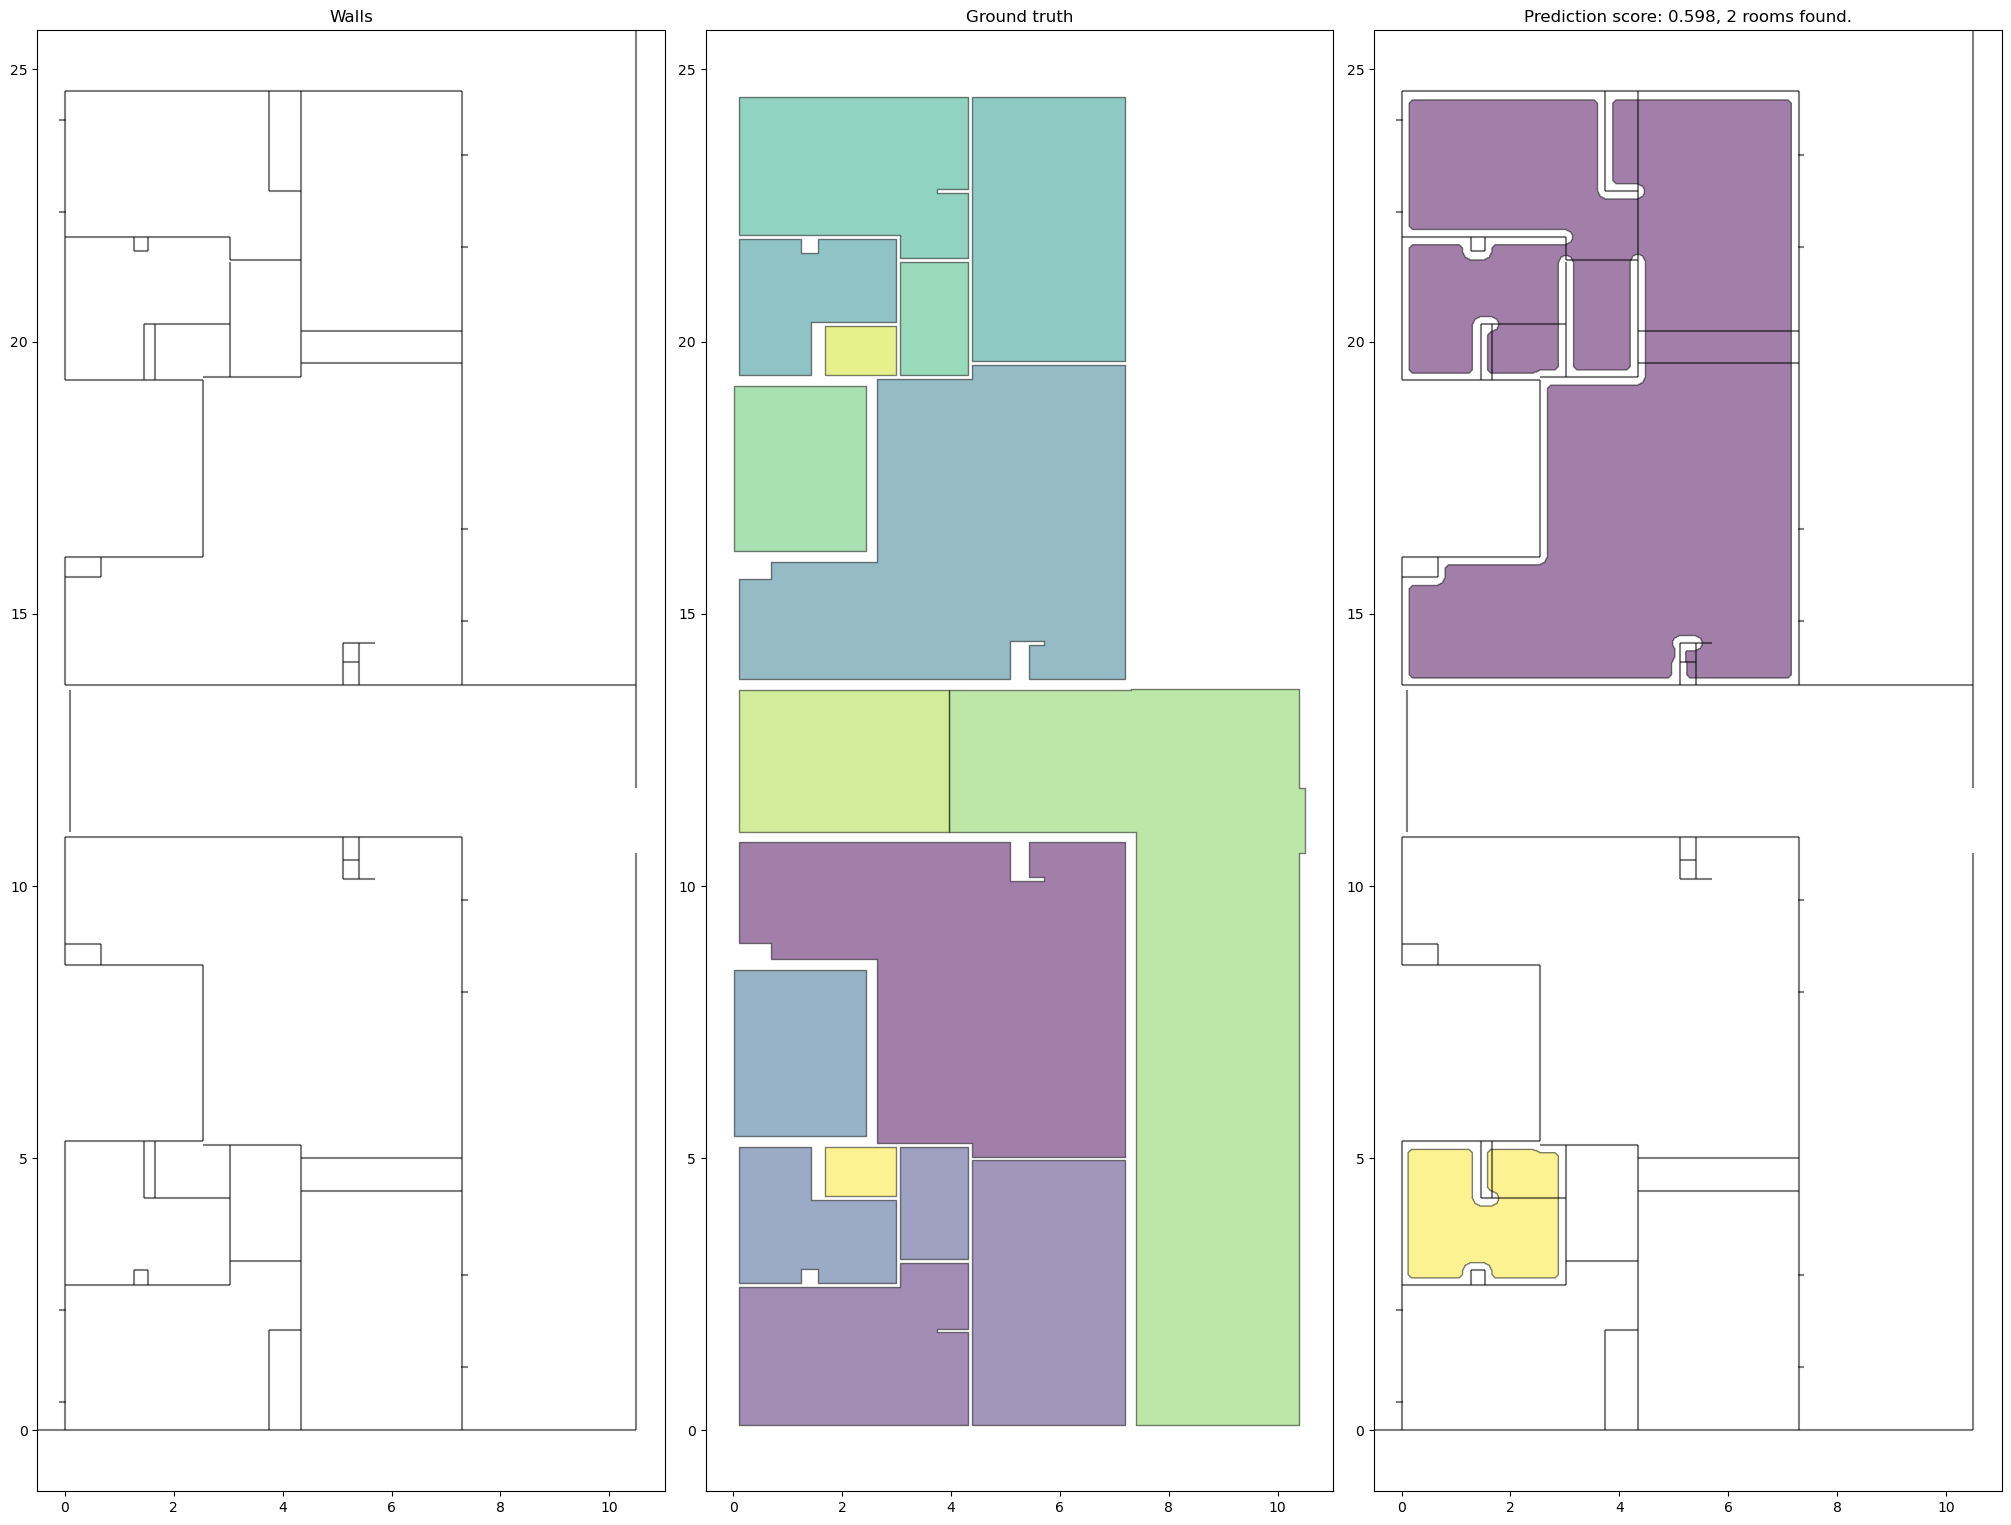

In [37]:
# Example with Computer vision
model = CVSegmentation(
    thickness=13, surf_min=0.3, surf_max=1_000, clean_segments=True
)
score = test_model_on_sample(
    model,
    sample_folder=validate_subfolder,
    metric=metric,
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Display the prediction
plot_score(model, validate_subfolder, metric).show()

In [ ]:
# Run it only on GPU

# from models.model_SAMSegmentation import SAMSegmentation

# model = SAMSegmentation()

# # Compute the metric
# score = test_model_on_sample(
#     model, sample_folder=validate_subfolder, metric=metric
# )
# print(
#     f"Score: {score:.3f} for {model.__name__} on folder "
#     f"{validate_subfolder} in with "
#     f"{metric.__name__}"
# )
# # Display the prediction
# plot_score(model, validate_subfolder, metric, show_iou=True).show()

### 5.2 Score on a whole dataset

In [41]:
# Score on the whole validation set
data_folder = Path("data/spaces-walls/Ecole Centrale Thomas/")
metric = average_matched_iou
model = SegmentBasedClustering()
score_model(model, data_folder, metric=metric)

SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:127: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_iou(geoms_true, geoms_pred))


Score: 0.766 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas in 6.94s with average_matched_iou


np.float64(0.76631387113348)

In [42]:
metric = average_iou
score_model(model, data_folder, metric=metric)

SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:59: RuntimeWarning: Mean of empty slice
  total_loss = np.nanmean(ious)


Score: 0.037 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas in 7.64s with average_iou


np.float64(0.03733605162551737)

In [43]:
model = CVSegmentation(thickness=3)
score_model(model, data_folder, metric=average_matched_iou)

Filter: keep 14/26
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 13/23
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 3/4
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: No segments found to generate binary image.
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: No segments found to generate binary image.
Filter: keep 3/4
Filter: keep 3/4
Filter: keep 106/162
Filter: keep 105/159
Filter: keep 19/25
Filter: keep 104/160


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:127: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_iou(geoms_true, geoms_pred))


Score: 0.773 for CVSegmentation(dpi:50, thickness:3, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas in 2.01s with average_matched_iou


np.float64(0.7728402141770863)

In [44]:
score_model(model, data_folder, metric=average_iou)

Filter: keep 14/26
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 13/23
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 13/23
Filter: keep 14/26
Filter: keep 3/4
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: No segments found to generate binary image.
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: No segments found to generate binary image.
Filter: keep 3/4
Filter: keep 3/4
Filter: keep 106/162
Filter: keep 105/159
Filter: keep 19/25
Filter: keep 104/160


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:59: RuntimeWarning: Mean of empty slice
  total_loss = np.nanmean(ious)


Score: 0.091 for CVSegmentation(dpi:50, thickness:3, dilatation:gaussian) on folder data/spaces-walls/Ecole Centrale Thomas in 2.70s with average_iou


np.float64(0.0909140466672362)

In [46]:
CVS_model = CapstoneVisionSegmentation()
score_model(CVS_model, data_folder, metric=average_matched_iou)

ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: Expecting value: line 1 column 53 (char 52)
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: Expecting value: line 1 column 53 (char 52)


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:127: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_iou(geoms_true, geoms_pred))


Score: 0.861 for CapstoneSegmentation(dpi:50, thickness:3, method_dilatation:gaussian, surface_min_m2:0.5, surface_min_px:1250.0) on folder data/spaces-walls/Ecole Centrale Thomas in 4.56s with average_matched_iou


np.float64(0.8605043379455426)

## 6. How to generate the final GeoJson file? 🆕

In [ ]:
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
# Call predict with the loaded geometry collection
y_pred = model(gc_raw)

pg.export_to_geojson(y_pred, Path("data/prediction") / "predict_5_001.geojson")
print(f"{len(y_pred.geoms)} rooms saved in GeoJson format.")

FileNotFoundError: [Errno 2] No such file or directory: 'data/prediction/predict_5_001.geojson'

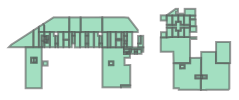

In [ ]:
# Load back to check
pg.load_geometrycollection_from_geojson(
    Path("data/prediction") / "predict_5_001.geojson"
)